# False Positive Brand Classifier

This notebook develops a text-based, binary classifier to detect whether a news article mentioning a sportswear brand name is actually about the sportswear company or something else (e.g., "Puma" the animal, "Patagonia" the region), a situation termed a false positive for the purposes of this project.

## Objective
Replace Claude's false positive detection with a cost-efficient ML classifier that can filter articles before expensive LLM labeling.

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - LLM can catch it later

We optimize for **F2 score** which weights recall 2x higher than precision. Pure recall optimization leads to degenerate solutions (predicting everything as positive), so F2 provides the right balance.

## Contents
1. [Data Loading & Exploration](#1-data-loading--exploration)
2. [Target Variable Analysis](#2-target-variable-analysis)
3. [Text Analysis & EDA](#3-text-analysis--eda)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Train/Validation/Test Split](#5-trainvalidationtest-split)
6. [Baseline Models](#6-baseline-models)
7. [Hyperparameter Tuning](#7-hyperparameter-tuning)
8. [Model Selection & Final Evaluation](#8-model-selection--final-evaluation)
9. [Threshold Tuning](#9-threshold-tuning)
10. [Conclusions](#10-conclusions)

## Setup

In [1]:
# Standard imports
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    plot_target_distribution,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    build_tfidf_pipeline,
    extract_brand_context,
    create_sportswear_vocab_df,
    create_enhanced_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.modeling import (
    create_search_object,
    tune_with_logging,
    get_best_params_summary,
    compare_models,
    get_best_model,
    evaluate_model,
    compare_val_test_performance,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading & Exploration

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 844 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 5.77 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     844 non-null    object
 1   title          844 non-null    object
 2   content        844 non-null    object
 3   brands         844 non-null    object
 4   is_sportswear  844 non-null    int64 
 5   source         844 non-null    object
 6   fp_reason      119 non-null    object
dtypes: int64(1), object(6)
memory usage: 46.3+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id         0
title              0
content            0
brands             0
is_sportswear      0
source             0
fp_reason        725
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           511
skipped           214
false_positive    119
Name: count, dtype: int64


## 2. Target Variable Analysis

TARGET VARIABLE ANALYSIS

Total samples: 844

Class distribution:
  Not Sportswear (FP): 119 (14.1%)
  Sportswear: 725 (85.9%)

Imbalance ratio: 6.09:1

[WARNING] Dataset is imbalanced (ratio >= 5.0)
Consider using:
  - Stratified sampling for train/val/test splits
  - Class weights or oversampling/undersampling
  - Appropriate metrics (PR-AUC, F1) over accuracy
Figure saved to images/fp_target_distribution.png


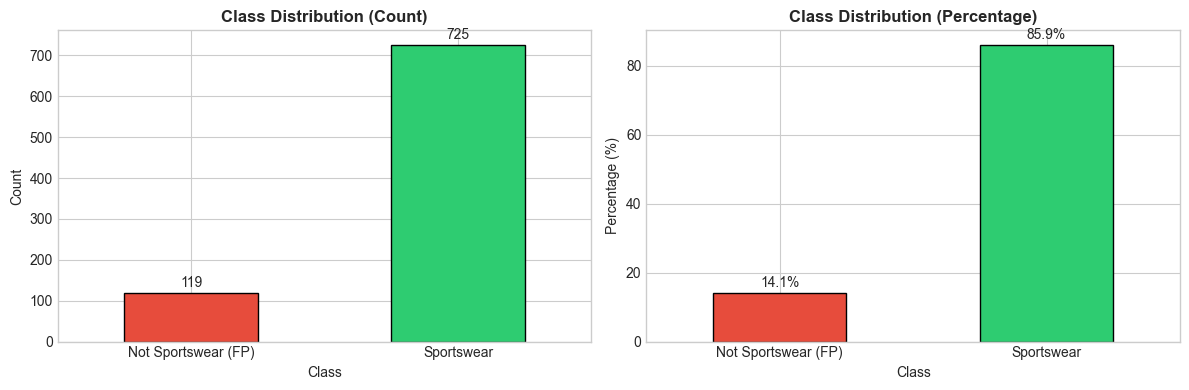

In [7]:
# Define target column and labels
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']

# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Text Analysis & EDA

### 3.1 Text Length Analysis

In [8]:
# Analyze text lengths
text_stats = analyze_text_length_stats(df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 844

Overall statistics:
  Character length: mean=3535, median=2496, range=[122, 51540]
  Word count: mean=572, median=398, range=[22, 8683]

By is_sportswear:
  Class 1:
    Chars: mean=3415, median=2453
    Words: mean=553, median=392
  Class 0:
    Chars: mean=4270, median=2776
    Words: mean=682, median=444


Figure saved to images/fp_text_length_dist.png


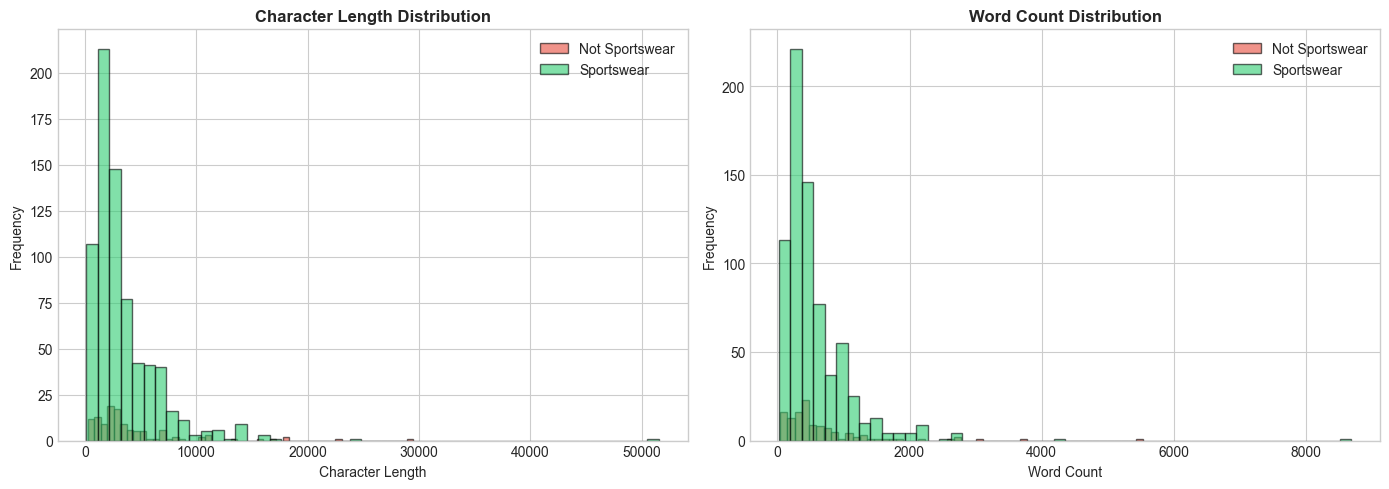

In [9]:
# Plot text length distributions by class
plot_text_length_distributions(
    df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 3.2 Brand Distribution

In [10]:
# Analyze brand distribution
brand_counts = analyze_brand_distribution(df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 887
Unique brands: 44

Top 15 brands:
  Nike: 189 (21.3%)
  Lululemon: 97 (10.9%)
  Adidas: 61 (6.9%)
  Puma: 51 (5.7%)
  Vans: 51 (5.7%)
  Hoka: 48 (5.4%)
  Patagonia: 33 (3.7%)
  Reebok: 29 (3.3%)
  Skechers: 29 (3.3%)
  Black Diamond: 28 (3.2%)
  New Balance: 26 (2.9%)
  Timberland: 26 (2.9%)
  Anta: 25 (2.8%)
  Salomon: 18 (2.0%)
  Converse: 15 (1.7%)

Brand distribution by is_sportswear:
  Class 0: 121 mentions, top: Black Diamond (27), Vans (21), Puma (13)
  Class 1: 766 mentions, top: Nike (188), Lululemon (97), Adidas (61)


Figure saved to images/fp_brand_dist.png


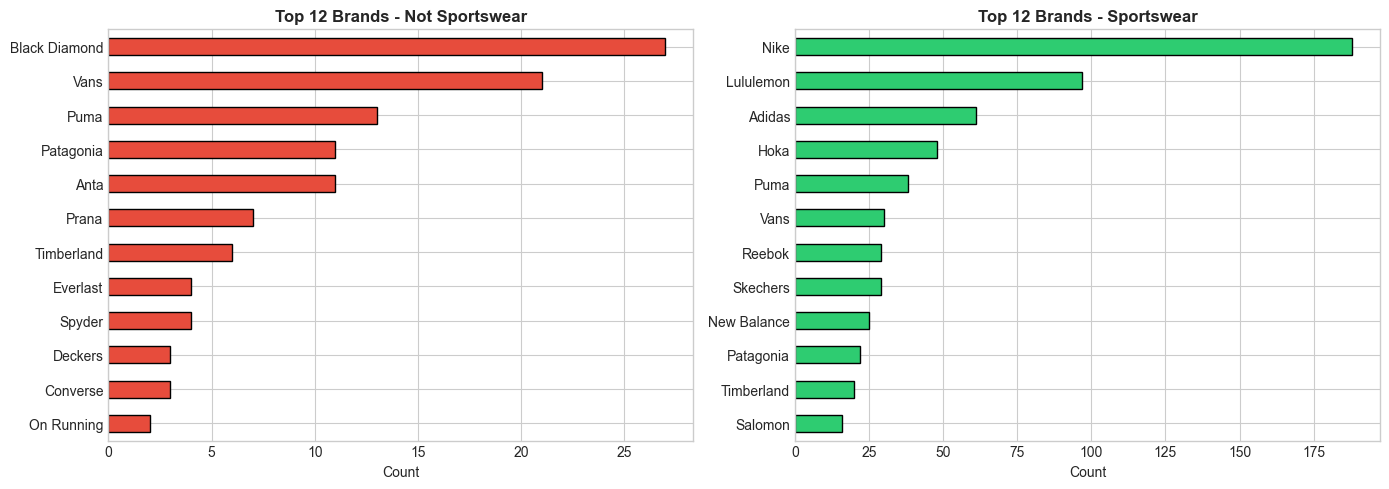

In [11]:
# Plot brand distribution by class
plot_brand_distribution(
    df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 3.3 Word Frequency Analysis

In [12]:
# Analyze word frequencies by class
word_freqs = analyze_word_frequencies(df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 204
  black: 143
  diamond: 137
  over: 133
  out: 117
  year: 112
  time: 103
  looking: 100
  across: 97
  people: 97
  puma: 96
  group: 94
  like: 93
  get: 93
  because: 87

Top 15 words for class_1:
  nike: 1,556
  company: 1,192
  brand: 998
  lululemon: 969
  year: 949
  out: 792
  running: 780
  like: 732
  shoe: 701
  stock: 688
  shoes: 642
  over: 634
  off: 610
  price: 593
  time: 579


In [13]:
# Look at some false positive examples
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES")
print("="*60)

fp_samples = df[df[TARGET_COL] == 0].sample(3, random_state=RANDOM_STATE)
for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES

Brands: ['Black Diamond']
Title: Hearing set between Wyoming County Board of Education and Black Diamond Power Company...
Reason: Black Diamond: Article is about Black Diamond Power Company, an electric utility company in West Virginia, not Black Diamond Equipment (the outdoor gear company)
----------------------------------------

Brands: ['Spyder']
Title: What It Like Living Out of a Priceless Porsche 918 Spyder Prototype for a Week...
Reason: Spyder: Article is about the Porsche 918 Spyder supercar, not Spyder ski apparel company
----------------------------------------

Brands: ['Puma']
Title: Puma Exploration Samples up to 126 g / t Gold at McKenzie and Launches Inaugural Drilling Program...
Reason: Auto-detected: Puma matched pattern '\bpuma\s+(exploration|mining|gold|drill)\b'
----------------------------------------


## 4. Data Preprocessing

In [14]:
# Create combined text features
# Include title (weighted), brands, and content
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:500]}...")

Text features created!
Sample:
mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners tweaking the french sporting goods manufacturer models such as the xt and reimagining them as slip on mules for fall 2025 the brands return with new apparel and footwear bolstered by an all new model known as...


In [15]:
# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"Records with empty text features: {empty_texts}")

# Remove if any
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records: {len(df)}")

Records with empty text features: 0


### 4.2 Enhanced Feature Engineering

We'll compare two additional feature engineering approaches to see if they improve classification:

1. **Brand Context Window**: Extract words within N words of brand mentions (emphasizes context)
2. **Sportswear Vocabulary Features**: Binary/count features for domain-specific vocabulary near brand mentions

In [16]:
# View the sportswear vocabulary categories
print("Sportswear Vocabulary Categories:")
print("=" * 50)
for category, words in SPORTSWEAR_VOCAB.items():
    print(f"\n{category.upper()}:")
    print(f"  {', '.join(sorted(words)[:15])}{'...' if len(words) > 15 else ''}")

Sportswear Vocabulary Categories:

FOOTWEAR:
  basketball, boot, boots, cleats, football, footwear, golf, hiking, running, sandals, shoe, shoes, skateboarding, sneaker, sneakers...

APPAREL:
  activewear, apparel, athleisure, athletic, clothing, coat, gear, hoodie, jacket, jersey, joggers, leggings, outfit, pants, shirt...

SPORTS_ACTIVITY:
  athletic, basketball, crossfit, cycling, exercise, fitness, football, golf, gym, marathon, running, soccer, sports, swimming, tennis...

RETAIL_BUSINESS:
  advertisement, brand, buy, campaign, collab, collaboration, collection, commercial, discount, ecommerce, endorsement, launch, partnership, price, purchase...


In [17]:
# Demonstrate brand context extraction on a sample
print("Brand Context Extraction Examples:")
print("=" * 60)

# Show one sportswear and one false positive example
samples = [
    df[df['is_sportswear'] == 1].iloc[0],  # Sportswear
    df[df['is_sportswear'] == 0].iloc[0],  # False positive
]

for sample in samples:
    brands = sample['brands']
    content = sample['content'][:1000]  # First 1000 chars
    context = extract_brand_context(content, brands, window_size=10)
    
    label = "SPORTSWEAR" if sample['is_sportswear'] == 1 else "FALSE POSITIVE"
    print(f"\n[{label}] Brands: {brands}")
    print(f"Context words (10-word window): {context[:200]}...")
    print("-" * 60)

Brand Context Extraction Examples:

[SPORTSWEAR] Brands: ['Salomon']
Context words (10-word window): the rihanna approved cross low model mm6 maison margiela and have been frequent partners tweaking the french sporting goods manufacturer an all new model known as the xt mm6 using s fan favorite xt li...
------------------------------------------------------------

[FALSE POSITIVE] Brands: ['Patagonia']
Context words (10-word window): by here are a few photos from my trip to click on graph for larger image the first photo is...
------------------------------------------------------------


In [18]:
# Create enhanced text features (with brand context emphasis)
df['text_features_enhanced'] = create_enhanced_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    include_context=True,
    context_window=10
)

print("Enhanced text features created!")
print(f"Original length: {df['text_features'].str.len().mean():.0f} chars")
print(f"Enhanced length: {df['text_features_enhanced'].str.len().mean():.0f} chars")

Enhanced text features created!
Original length: 3499 chars
Enhanced length: 4283 chars


In [19]:
# Create sportswear vocabulary features
vocab_features_df = create_sportswear_vocab_df(
    df,
    text_col='content',
    brands_col='brands',
    window_size=15
)

print(f"Vocabulary features created: {vocab_features_df.shape[1]} features")
print(f"\nFeature names: {list(vocab_features_df.columns)}")

# Show mean values by class
print("\nMean vocabulary feature values by class:")
vocab_with_target = vocab_features_df.copy()
vocab_with_target['is_sportswear'] = df['is_sportswear'].values
print(vocab_with_target.groupby('is_sportswear').mean().round(2).T)

Vocabulary features created: 14 features

Feature names: ['vocab_footwear_count', 'vocab_footwear_any', 'vocab_footwear_near_brand', 'vocab_apparel_count', 'vocab_apparel_any', 'vocab_apparel_near_brand', 'vocab_sports_activity_count', 'vocab_sports_activity_any', 'vocab_sports_activity_near_brand', 'vocab_retail_business_count', 'vocab_retail_business_any', 'vocab_retail_business_near_brand', 'vocab_total_matches', 'vocab_near_brand_total']

Mean vocabulary feature values by class:
is_sportswear                        0     1
vocab_footwear_count              0.17  1.94
vocab_footwear_any                0.12  0.66
vocab_footwear_near_brand         0.03  1.18
vocab_apparel_count               0.08  1.51
vocab_apparel_any                 0.08  0.64
vocab_apparel_near_brand          0.02  0.80
vocab_sports_activity_count       0.30  1.20
vocab_sports_activity_any         0.18  0.57
vocab_sports_activity_near_brand  0.04  0.63
vocab_retail_business_count       1.29  2.64
vocab_retail_busi

## 5. Train/Validation/Test Split

In [20]:
# Split with stratification
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

TRAIN/VALIDATION/TEST SPLIT

Total samples: 844

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      506 (60.0%)
  Validation: 169 (20.0%)
  Test:       169 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 86.0%, 0: 14.0%
  Val: 1: 85.8%, 0: 14.2%
  Test: 1: 85.8%, 0: 14.2%


In [21]:
# Prepare feature and target arrays
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

X_test = test_df['text_features']
y_test = test_df[TARGET_COL]

# Combine train+val for hyperparameter tuning (CV will create its own internal splits)
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

print(f"X_train shape: {len(X_train)}")
print(f"X_val shape: {len(X_val)}")
print(f"X_test shape: {len(X_test)}")
print(f"X_trainval shape: {len(X_trainval)} (for hyperparameter tuning)")

X_train shape: 506
X_val shape: 169
X_test shape: 169
X_trainval shape: 675 (for hyperparameter tuning)


## 6. Baseline Models

In [22]:
# Build TF-IDF vectorizer (fit on training data only)
tfidf_pipeline = build_tfidf_pipeline(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit and transform
X_train_tfidf = tfidf_pipeline.fit_transform(X_train)
X_val_tfidf = tfidf_pipeline.transform(X_val)
X_test_tfidf = tfidf_pipeline.transform(X_test)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")

TF-IDF features: 10000


In [23]:
# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'),
        cv=3
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
}

In [24]:
# Train and evaluate baseline models
# Create F2 scorer (weights recall 2x higher than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)

baseline_results = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_model(
        model, X_val_tfidf, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=True,
        plot=False
    )
    
    # Add F2 score to metrics (recall-weighted)
    y_pred = model.predict(X_val_tfidf)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    print(f"  F2 Score:  {metrics['f2']:.4f} (recall-weighted)")
    
    baseline_results.append(metrics)


Training Logistic Regression...

MODEL EVALUATION: Logistic Regression on Validation

Classification Metrics:
  Accuracy:  0.9231
  Precision: 0.9648
  Recall:    0.9448
  F1 Score:  0.9547
  ROC-AUC:   0.9624
  PR-AUC:    0.9941

Confusion Matrix:
  TN: 19  FP: 5
  FN: 8  TP: 137

                precision    recall  f1-score   support

Not Sportswear       0.70      0.79      0.75        24
    Sportswear       0.96      0.94      0.95       145

      accuracy                           0.92       169
     macro avg       0.83      0.87      0.85       169
  weighted avg       0.93      0.92      0.92       169

  F2 Score:  0.9488 (recall-weighted)

Training Naive Bayes...

MODEL EVALUATION: Naive Bayes on Validation

Classification Metrics:
  Accuracy:  0.8698
  Precision: 0.8683
  Recall:    1.0000
  F1 Score:  0.9295
  ROC-AUC:   0.9299
  PR-AUC:    0.9876

Confusion Matrix:
  TN: 2  FP: 22
  FN: 0  TP: 145

                precision    recall  f1-score   support

Not Sportswear

### 6.2 Feature Engineering Comparison

Now let's compare different feature engineering approaches using Logistic Regression as our baseline model:

1. **Original**: TF-IDF on title + brands + content
2. **Enhanced Text**: TF-IDF with brand context window emphasis  
3. **TF-IDF + Vocab**: Original TF-IDF combined with sportswear vocabulary features
4. **Enhanced + Vocab**: Enhanced text TF-IDF combined with vocabulary features

In [25]:
# Prepare different feature sets for comparison
# Use the same train/val split indices

# 1. Original TF-IDF (already computed as X_train_tfidf, X_val_tfidf)
# (Already done above)

# 2. Enhanced text TF-IDF (with brand context)
X_train_enhanced = train_df['text_features_enhanced']
X_val_enhanced = val_df['text_features_enhanced']

tfidf_enhanced = build_tfidf_pipeline(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_enhanced_tfidf = tfidf_enhanced.fit_transform(X_train_enhanced)
X_val_enhanced_tfidf = tfidf_enhanced.transform(X_val_enhanced)

print(f"Enhanced TF-IDF features: {X_train_enhanced_tfidf.shape[1]}")

# 3. Vocabulary features for train/val
vocab_train = vocab_features_df.loc[train_df.index].values
vocab_val = vocab_features_df.loc[val_df.index].values

print(f"Vocabulary features: {vocab_train.shape[1]}")

# 4. Combined: Original TF-IDF + Vocabulary
X_train_combined = sparse.hstack([X_train_tfidf, vocab_train])
X_val_combined = sparse.hstack([X_val_tfidf, vocab_val])

print(f"Combined (Original + Vocab) features: {X_train_combined.shape[1]}")

# 5. Combined: Enhanced TF-IDF + Vocabulary
X_train_enhanced_combined = sparse.hstack([X_train_enhanced_tfidf, vocab_train])
X_val_enhanced_combined = sparse.hstack([X_val_enhanced_tfidf, vocab_val])

print(f"Combined (Enhanced + Vocab) features: {X_train_enhanced_combined.shape[1]}")

Enhanced TF-IDF features: 10000
Vocabulary features: 14
Combined (Original + Vocab) features: 10014
Combined (Enhanced + Vocab) features: 10014


In [26]:
# Compare feature approaches using Logistic Regression
feature_configs = {
    '1_Original_TF-IDF': (X_train_tfidf, X_val_tfidf),
    '2_Enhanced_TF-IDF': (X_train_enhanced_tfidf, X_val_enhanced_tfidf),
    '3_Original+Vocab': (X_train_combined, X_val_combined),
    '4_Enhanced+Vocab': (X_train_enhanced_combined, X_val_enhanced_combined),
}

feature_results = []

for name, (X_train_feat, X_val_feat) in feature_configs.items():
    print(f"\nTraining on {name}...")
    
    # Train Logistic Regression with same params
    lr = LogisticRegression(
        C=0.01,
        penalty='l2',
        solver='saga',
        max_iter=2000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )
    lr.fit(X_train_feat, y_train)
    
    # Evaluate
    metrics = evaluate_model(
        lr, X_val_feat, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=False,
        plot=False
    )
    
    # Add F2 score
    y_pred = lr.predict(X_val_feat)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    
    feature_results.append(metrics)
    
    print(f"  Recall: {metrics['recall']:.4f}, F2: {metrics['f2']:.4f}, Precision: {metrics['precision']:.4f}")


Training on 1_Original_TF-IDF...
  Recall: 0.9448, F2: 0.9501, Precision: 0.9716

Training on 2_Enhanced_TF-IDF...
  Recall: 0.9448, F2: 0.9501, Precision: 0.9716

Training on 3_Original+Vocab...
  Recall: 0.7655, F2: 0.8020, Precision: 0.9911

Training on 4_Enhanced+Vocab...
  Recall: 0.7655, F2: 0.8020, Precision: 0.9911



Feature Engineering Comparison (Logistic Regression)
                   recall      f2  precision      f1  accuracy  pr_auc
model_name                                                            
1_Original_TF-IDF  0.9448  0.9501     0.9716  0.9580    0.9290  0.9943
2_Enhanced_TF-IDF  0.9448  0.9501     0.9716  0.9580    0.9290  0.9938
3_Original+Vocab   0.7655  0.8020     0.9911  0.8638    0.7929  0.9829
4_Enhanced+Vocab   0.7655  0.8020     0.9911  0.8638    0.7929  0.9826

Figure saved to images/fp_feature_comparison.png


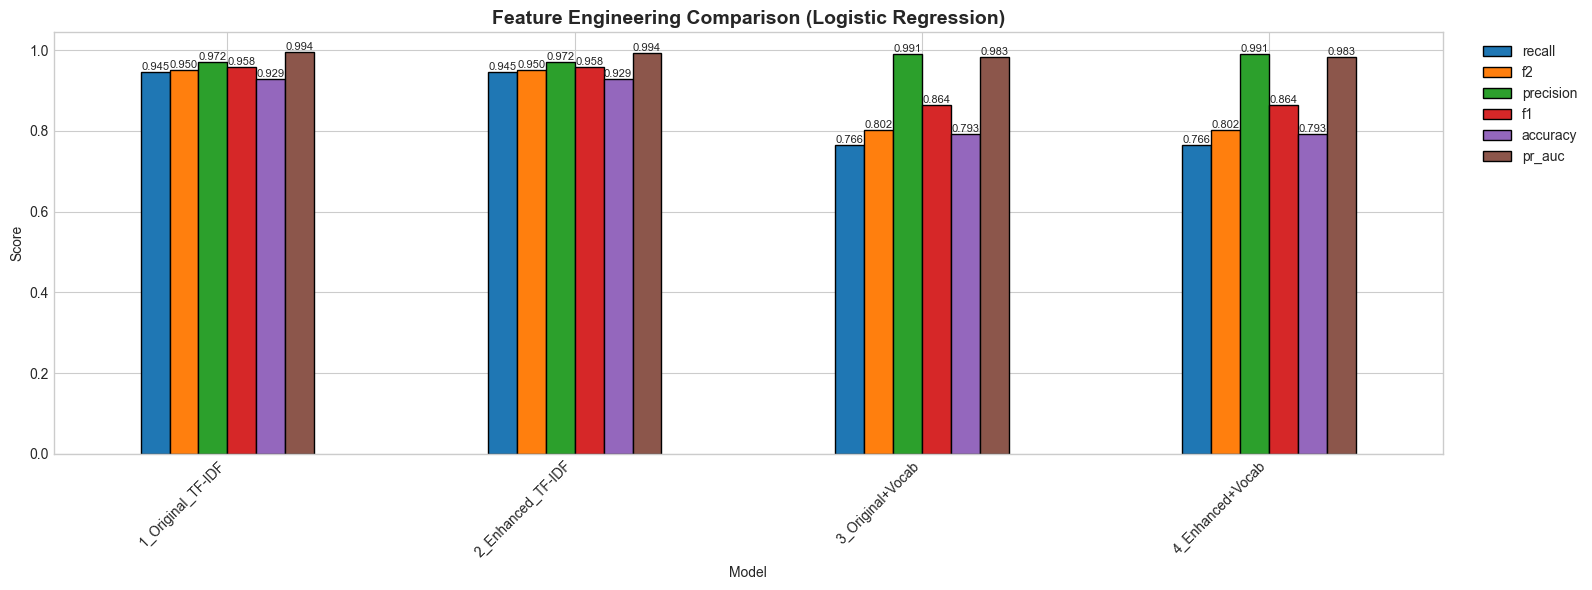


FEATURE ENGINEERING IMPACT SUMMARY
1_Original_TF-IDF: Recall = 0.9448 (+0.0000 vs baseline), F2 = 0.9501
2_Enhanced_TF-IDF: Recall = 0.9448 (+0.0000 vs baseline), F2 = 0.9501
3_Original+Vocab: Recall = 0.7655 (-0.1793 vs baseline), F2 = 0.8020
4_Enhanced+Vocab: Recall = 0.7655 (-0.1793 vs baseline), F2 = 0.8020


In [27]:
# Compare feature engineering approaches (with recall prioritized)
feature_comparison = compare_models(
    feature_results,
    metrics_to_display=['recall', 'f2', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Feature Engineering Comparison (Logistic Regression)',
    save_path='images/fp_feature_comparison.png'
)

# Highlight the differences
print("\n" + "="*60)
print("FEATURE ENGINEERING IMPACT SUMMARY")
print("="*60)
baseline_recall = feature_results[0]['recall']
for i, (name, metrics) in enumerate(zip(feature_configs.keys(), feature_results)):
    diff = metrics['recall'] - baseline_recall
    sign = "+" if diff >= 0 else ""
    print(f"{name}: Recall = {metrics['recall']:.4f} ({sign}{diff:.4f} vs baseline), F2 = {metrics['f2']:.4f}")


Baseline Model Comparison (Validation Set)
                     recall      f2  precision      f1  accuracy  pr_auc
model_name                                                              
Logistic Regression  0.9448  0.9488     0.9648  0.9547    0.9231  0.9941
Naive Bayes          1.0000  0.9705     0.8683  0.9295    0.8698  0.9876
Linear SVM           0.9448  0.9409     0.9257  0.9352    0.8876  0.9935
Random Forest        1.0000  0.9784     0.9006  0.9477    0.9053  0.9906

Figure saved to images/fp_baseline_comparison.png


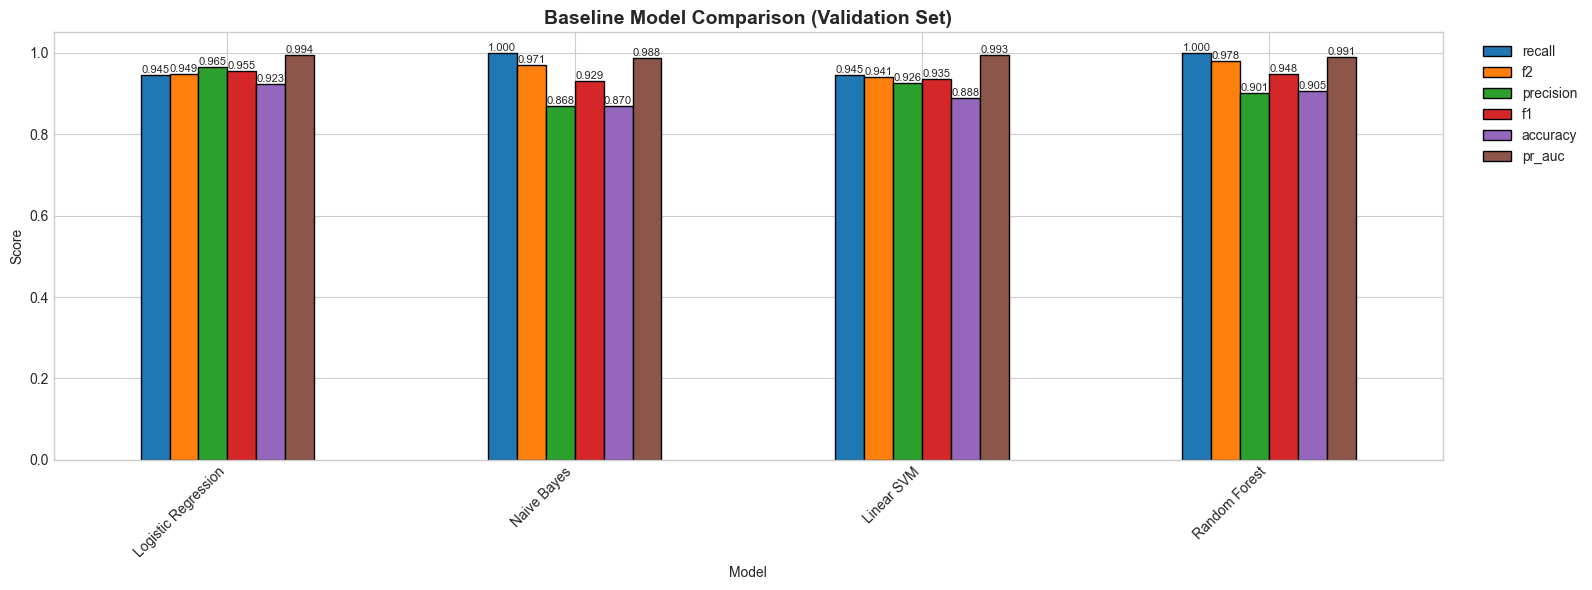

In [28]:
# Compare baseline models (with recall and f2 prioritized)
baseline_comparison = compare_models(
    baseline_results,
    metrics_to_display=['recall', 'f2', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Baseline Model Comparison (Validation Set)',
    save_path='images/fp_baseline_comparison.png'
)

## 7. Hyperparameter Tuning

For hyperparameter tuning, we combine the train and validation sets (80% of data) and use cross-validation to find optimal parameters. This gives us more data for robust hyperparameter estimation since CV creates its own internal train/validation splits. The test set (20%) remains completely held out for final evaluation.

In [29]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

### 7.1 TF-IDF Parameter Tuning

Before tuning classifier parameters, let's find the optimal TF-IDF configuration. We'll tune:
- **max_features**: Vocabulary size (5000, 10000, 15000)
- **sublinear_tf**: Log scaling of term frequency (True/False)
- **norm**: Vector normalization ('l1', 'l2', None)

Fixed parameters: `ngram_range=(1,2)`, `min_df=2`, `max_df=0.95`

In [30]:
# Create a pipeline with TF-IDF + Logistic Regression
tfidf_lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english',
        strip_accents='unicode',
        lowercase=True,
        token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b',
    )),
    ('clf', LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        solver='saga',
    ))
])

# Parameter grid for TF-IDF + classifier
tfidf_param_grid = {
    # TF-IDF parameters
    'tfidf__max_features': [5000, 7500, 10000],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    # Classifier parameters (use best from prior knowledge)
    'clf__C': [0.01, 0.1],
    'clf__class_weight': ['balanced'],
    'clf__penalty': ['l2'],
}

print(f"TF-IDF + LR Pipeline parameter grid:")
total_combos = 1
for param, values in tfidf_param_grid.items():
    print(f"  {param}: {values}")
    total_combos *= len(values)
print(f"\nTotal combinations: {total_combos}")
print(f"Total fits (4-fold CV): {total_combos * 4}")

TF-IDF + LR Pipeline parameter grid:
  tfidf__max_features: [5000, 7500, 10000]
  tfidf__sublinear_tf: [True, False]
  tfidf__norm: ['l1', 'l2']
  clf__C: [0.01, 0.1]
  clf__class_weight: ['balanced']
  clf__penalty: ['l2']

Total combinations: 24
Total fits (4-fold CV): 96


In [ ]:
# Run GridSearchCV for TF-IDF + LR pipeline
# Use combined train+val data for more robust hyperparameter estimation
# IMPORTANT: Refit on F2 - balances recall (2x weight) with precision to avoid degenerate solutions
tfidf_search = GridSearchCV(
    tfidf_lr_pipeline,
    tfidf_param_grid,
    cv=cv,
    scoring={
        'accuracy': 'accuracy',
        'f1': 'f1',
        'f2': f2_scorer,
        'precision': 'precision',
        'recall': 'recall',
        'average_precision': 'average_precision',
    },
    refit='f2',  # F2 weights recall 2x but requires precision too
    n_jobs=-1,
    verbose=1,
    return_train_score=False,
)

print("Starting TF-IDF + LR hyperparameter search...")
print(f"Using {len(X_trainval)} samples (train+val combined)")
print("Optimizing for: F2 (recall-weighted, prevents 'predict all positive' trap)")
tfidf_search.fit(X_trainval, y_trainval)
print(f"\nBest score (F2): {tfidf_search.best_score_:.4f}")

In [ ]:
# Display best TF-IDF parameters
print("=" * 60)
print("BEST TF-IDF + LOGISTIC REGRESSION PARAMETERS")
print("=" * 60)

print("\nBest parameters:")
for param, value in tfidf_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV score (F2): {tfidf_search.best_score_:.4f}")

# Get CV results for best model
best_idx = tfidf_search.best_index_
cv_results = tfidf_search.cv_results_

print("\nCV Metrics for best configuration:")
for metric in ['f2', 'recall', 'precision', 'f1', 'accuracy', 'average_precision']:
    mean_score = cv_results[f'mean_test_{metric}'][best_idx]
    std_score = cv_results[f'std_test_{metric}'][best_idx]
    marker = " <-- PRIMARY" if metric == 'f2' else ""
    print(f"  {metric}: {mean_score:.4f} (+/- {std_score:.4f}){marker}")

In [33]:
# Analyze impact of each TF-IDF parameter
results_df = pd.DataFrame(tfidf_search.cv_results_)

# Show top 10 configurations by RECALL
top_configs = results_df.nsmallest(10, 'rank_test_recall')[
    ['param_tfidf__max_features', 'param_tfidf__sublinear_tf', 'param_tfidf__norm',
     'param_clf__C', 'mean_test_recall', 'std_test_recall', 
     'mean_test_precision', 'mean_test_f2', 'rank_test_recall']
].rename(columns={
    'param_tfidf__max_features': 'max_features',
    'param_tfidf__sublinear_tf': 'sublinear_tf', 
    'param_tfidf__norm': 'norm',
    'param_clf__C': 'C',
    'mean_test_recall': 'Recall',
    'std_test_recall': 'Recall_std',
    'mean_test_precision': 'Precision',
    'mean_test_f2': 'F2',
    'rank_test_recall': 'Rank'
})

print("Top 10 TF-IDF Configurations (by RECALL):")
print(top_configs.to_string(index=False))

Top 10 TF-IDF Configurations (by RECALL):
 max_features  sublinear_tf norm    C   Recall  Recall_std  Precision       F2  Rank
        10000          True   l2 0.10 0.946552    0.019122   0.959961 0.949132     1
         5000          True   l2 0.10 0.943103    0.021465   0.966492 0.947635     2
        10000          True   l2 0.01 0.941379    0.017241   0.957187 0.944277     3
         7500          True   l2 0.10 0.941379    0.022612   0.959748 0.944902     3
         7500          True   l2 0.01 0.939655    0.015708   0.960265 0.943537     5
        10000         False   l2 0.10 0.932759    0.017835   0.952817 0.936576     6
         5000          True   l2 0.01 0.931034    0.020690   0.963601 0.937115     7
         7500         False   l2 0.10 0.931034    0.016174   0.954566 0.935496     7
         5000         False   l2 0.10 0.929310    0.019122   0.957803 0.934713     9
        10000         False   l2 0.01 0.927586    0.014218   0.957776 0.933335    10


In [34]:
# Evaluate best TF-IDF pipeline on held-out test set
best_tfidf_pipeline = tfidf_search.best_estimator_

# Get predictions for test set (the only data not seen during tuning)
tfidf_test_metrics = evaluate_model(
    best_tfidf_pipeline, X_test, y_test,
    model_name='TF-IDF_Tuned_LR',
    dataset_name='Test',
    verbose=True,
    plot=False
)

print("\n" + "=" * 60)
print("TF-IDF + LR TUNING RESULTS (Optimized for RECALL)")
print("=" * 60)
print(f"Best CV Recall:  {tfidf_search.best_score_:.4f}")
print(f"Test Recall:     {tfidf_test_metrics['recall']:.4f}")
print(f"Test Precision:  {tfidf_test_metrics['precision']:.4f} (acceptable trade-off)")


MODEL EVALUATION: TF-IDF_Tuned_LR on Test

Classification Metrics:
  Accuracy:  0.8994
  Precision: 0.9444
  Recall:    0.9379
  F1 Score:  0.9412
  ROC-AUC:   0.9506
  PR-AUC:    0.9920

Confusion Matrix:
  TN: 16  FP: 8
  FN: 9  TP: 136

                precision    recall  f1-score   support

Not Sportswear       0.64      0.67      0.65        24
    Sportswear       0.94      0.94      0.94       145

      accuracy                           0.90       169
     macro avg       0.79      0.80      0.80       169
  weighted avg       0.90      0.90      0.90       169


TF-IDF + LR TUNING RESULTS (Optimized for RECALL)
Best CV Recall:  0.9466
Test Recall:     0.9379
Test Precision:  0.9444 (acceptable trade-off)


In [35]:
# Extract best TF-IDF parameters and create optimized features for other classifiers
best_tfidf_params = {k.replace('tfidf__', ''): v for k, v in tfidf_search.best_params_.items() 
                     if k.startswith('tfidf__')}

print("Best TF-IDF Parameters:")
for param, value in best_tfidf_params.items():
    print(f"  {param}: {value}")

# Create optimized TF-IDF vectorizer
tfidf_opt = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english',
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b',
    **best_tfidf_params
)

# Fit on combined train+val, transform test separately
X_trainval_tfidf_opt = tfidf_opt.fit_transform(X_trainval)
X_test_tfidf_opt = tfidf_opt.transform(X_test)

print(f"\nOptimized TF-IDF features: {X_trainval_tfidf_opt.shape[1]}")
print(f"Train+Val samples: {X_trainval_tfidf_opt.shape[0]}")
print(f"Test samples: {X_test_tfidf_opt.shape[0]}")

Best TF-IDF Parameters:
  max_features: 10000
  norm: l2
  sublinear_tf: True

Optimized TF-IDF features: 10000
Train+Val samples: 675
Test samples: 169


### 7.2 Logistic Regression Tuning (with Optimized TF-IDF)

Now that we have the optimal TF-IDF parameters, let's tune Logistic Regression hyperparameters using the optimized features. We optimize for **F2 score** which weights recall 2x higher than precision, preventing degenerate "predict all positive" solutions.

In [ ]:
# Logistic Regression parameter grid (using optimized TF-IDF features)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'class_weight': ['balanced', None],
}

lr_search = create_search_object(
    search_type='grid',
    estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=cv,
    refit='f2'  # F2 weights recall 2x but requires precision too
)

# Use combined train+val with optimized TF-IDF features
lr_search, lr_log, lr_csv = tune_with_logging(
    lr_search, X_trainval_tfidf_opt, y_trainval,
    model_name='logistic_regression_opt'
)

### 7.3 Random Forest Tuning

In [ ]:
# Random Forest parameter grid (using optimized TF-IDF features)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample'],
}

rf_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    refit='f2'  # F2 weights recall 2x but requires precision too
)

# Use combined train+val with optimized TF-IDF features
rf_search, rf_log, rf_csv = tune_with_logging(
    rf_search, X_trainval_tfidf_opt, y_trainval,
    model_name='random_forest_opt'
)

### 7.4 Gradient Boosting Tuning

In [ ]:
# Gradient Boosting parameter grid (using optimized TF-IDF features)
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0],
}

gb_search = create_search_object(
    search_type='grid',
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=gb_param_grid,
    cv=cv,
    refit='f2'  # F2 weights recall 2x but requires precision too
)

# Use combined train+val with optimized TF-IDF features
gb_search, gb_log, gb_csv = tune_with_logging(
    gb_search, X_trainval_tfidf_opt, y_trainval,
    model_name='gradient_boosting_opt'
)

### 7.5 Compare Tuned Models (CV Performance)

Compare models based on their cross-validation F2 scores. Model selection should be based on CV performance, not test set performance.

In [39]:
# Compare tuned models based on CV performance (NOT test set)
# Primary metric: RECALL (to minimize missed sportswear articles)
tuned_models = {
    'LR_tuned': lr_search,
    'RF_tuned': rf_search,
    'GB_tuned': gb_search,
}

# Extract CV metrics for comparison
cv_comparison_data = []
for name, search in tuned_models.items():
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    metrics = {
        'model_name': name,
        'recall': cv_results['mean_test_recall'][best_idx],
        'f2': cv_results['mean_test_f2'][best_idx],
        'precision': cv_results['mean_test_precision'][best_idx],
        'f1': cv_results['mean_test_f1'][best_idx],
        'accuracy': cv_results['mean_test_accuracy'][best_idx],
        'pr_auc': cv_results['mean_test_average_precision'][best_idx],
    }
    cv_comparison_data.append(metrics)
    
    print(f"{name}: CV Recall = {metrics['recall']:.4f} (+/- {cv_results['std_test_recall'][best_idx]:.4f}), F2 = {metrics['f2']:.4f}, Precision = {metrics['precision']:.4f}")

LR_tuned: CV Recall = 1.0000 (+/- 0.0000), F2 = 0.9683, Precision = 0.8593
RF_tuned: CV Recall = 0.9897 (+/- 0.0060), F2 = 0.9706, Precision = 0.9012
GB_tuned: CV Recall = 0.9879 (+/- 0.0057), F2 = 0.9702, Precision = 0.9056


In [ ]:
# Compare tuned models based on CV scores (F2 first as primary metric)
tuned_comparison = compare_models(
    cv_comparison_data,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Tuned Model Comparison (CV Performance, Optimized for F2)',
    save_path='images/fp_tuned_comparison.png'
)

## 8. Model Selection & Final Evaluation

The models were tuned on combined train+val data (80%) using cross-validation. Now we evaluate on the held-out test set (20%) which was never seen during any tuning process.

In [ ]:
# Select best model based on CV F2 (NOT test set performance)
best_model_name, best_model_metrics = get_best_model(tuned_comparison, 'f2')
print(f"\nSelected model: {best_model_name}")
print(f"CV F2: {best_model_metrics['f2']:.4f} (primary metric)")
print(f"CV Recall: {best_model_metrics['recall']:.4f}")
print(f"CV Precision: {best_model_metrics['precision']:.4f}")


MODEL EVALUATION: LR_tuned on Test

Classification Metrics:
  Accuracy:  0.8580
  Precision: 0.8580
  Recall:    1.0000
  F1 Score:  0.9236
  ROC-AUC:   0.5000
  PR-AUC:    0.8580

Confusion Matrix:
  TN: 0  FP: 24
  FN: 0  TP: 145

                precision    recall  f1-score   support

Not Sportswear       0.00      0.00      0.00        24
    Sportswear       0.86      1.00      0.92       145

      accuracy                           0.86       169
     macro avg       0.43      0.50      0.46       169
  weighted avg       0.74      0.86      0.79       169

Figure saved to images/fp_best_model_test.png


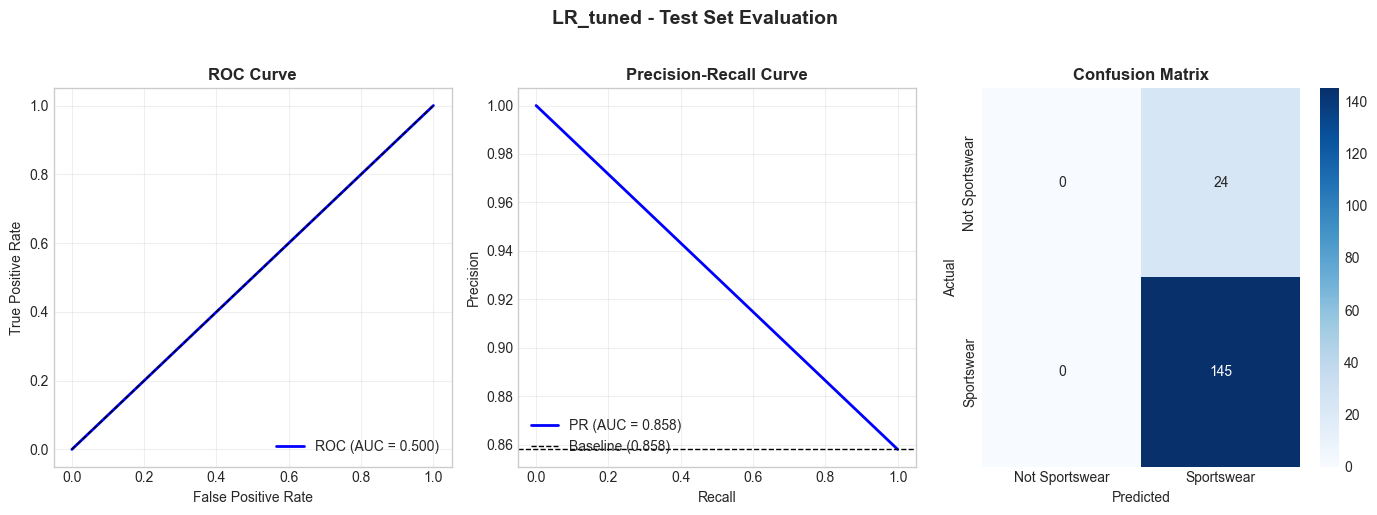

  F2 Score:  0.9680 (recall-weighted)


In [42]:
# Get the best model (selected based on CV performance)
best_search = tuned_models[best_model_name]
best_model = best_search.best_estimator_

# Now evaluate ONLY the selected model on the held-out test set
# This is the only time we use the test set for this model
test_metrics = evaluate_model(
    best_model, X_test_tfidf_opt, y_test,
    model_name=best_model_name,
    dataset_name='Test',
    verbose=True,
    plot=True,
    save_path='images/fp_best_model_test.png'
)

# Add F2 score to test metrics
y_pred_test = best_model.predict(X_test_tfidf_opt)
test_metrics['f2'] = fbeta_score(y_test, y_pred_test, beta=2)
print(f"  F2 Score:  {test_metrics['f2']:.4f} (recall-weighted)")

In [ ]:
# Compare CV score vs Test score for the selected model
print("=" * 60)
print("CV vs TEST PERFORMANCE (Selected Model)")
print("=" * 60)

cv_results = best_search.cv_results_
best_idx = best_search.best_index_

print(f"\nModel: {best_model_name}")
print(f"\nCV Performance (used for model selection):")
for metric in ['f2', 'recall', 'precision', 'f1', 'accuracy']:
    mean_score = cv_results[f'mean_test_{metric}'][best_idx]
    std_score = cv_results[f'std_test_{metric}'][best_idx]
    marker = " <-- PRIMARY" if metric == 'f2' else ""
    print(f"  {metric}: {mean_score:.4f} (+/- {std_score:.4f}){marker}")

print(f"\nTest Performance (held-out 20%):")
print(f"  f2: {test_metrics['f2']:.4f} <-- PRIMARY")
print(f"  recall: {test_metrics['recall']:.4f}")
print(f"  precision: {test_metrics['precision']:.4f}")
print(f"  f1: {test_metrics['f1']:.4f}")
print(f"  accuracy: {test_metrics['accuracy']:.4f}")

# Check for overfitting on F2
cv_f2 = cv_results['mean_test_f2'][best_idx]
test_f2 = test_metrics['f2']
diff = test_f2 - cv_f2
print(f"\nF2 difference (test - CV): {diff:+.4f}")
if abs(diff) <= 0.05:
    print(f"[OK] Model generalizes well (F2 diff within 5%)")
elif diff < -0.05:
    print(f"[WARNING] Possible overfitting - test F2 lower than CV F2")
else:
    print(f"[OK] Test performance exceeds CV (no overfitting)")
print("=" * 60)

In [44]:
# Save the best model and optimized TF-IDF vectorizer for deployment
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

# Save model
model_path = models_dir / 'fp_classifier_model.joblib'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save optimized TF-IDF vectorizer
tfidf_path = models_dir / 'fp_classifier_tfidf.joblib'
joblib.dump(tfidf_opt, tfidf_path)
print(f"Optimized TF-IDF vectorizer saved to {tfidf_path}")

# Print best TF-IDF params for reference
print(f"\nBest TF-IDF params: {best_tfidf_params}")

Model saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_model.joblib
Optimized TF-IDF vectorizer saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_tfidf.joblib

Best TF-IDF params: {'max_features': 10000, 'norm': 'l2', 'sublinear_tf': True}


## 9. Threshold Tuning

The default decision threshold is 0.5, but we can adjust it to further increase recall at the cost of precision. Since our goal is to minimize missed sportswear articles (and the LLM can catch false positives later), we'll find a threshold that achieves our target recall.

In [45]:
# Analyze precision-recall trade-off at different thresholds
y_proba = best_model.predict_proba(X_test_tfidf_opt)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find thresholds for different target recall levels
target_recalls = [0.95, 0.97, 0.98, 0.99]

print("=" * 70)
print("THRESHOLD ANALYSIS: Recall vs Precision Trade-off")
print("=" * 70)
print("\nTarget Recall | Threshold | Actual Recall | Precision | FPs Passed")
print("-" * 70)

for target in target_recalls:
    # Find threshold that achieves at least this recall
    idx = np.where(recalls >= target)[0]
    if len(idx) > 0:
        best_idx = idx[-1]  # Highest threshold that still meets recall target
        threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.0
        actual_recall = recalls[best_idx]
        precision = precisions[best_idx]
        
        # Calculate expected FPs that will pass to LLM
        y_pred_custom = (y_proba >= threshold).astype(int)
        fp_count = ((y_pred_custom == 1) & (y_test == 0)).sum()
        total_fp = (y_test == 0).sum()
        
        print(f"    {target:.0%}      |   {threshold:.3f}   |    {actual_recall:.1%}      |   {precision:.1%}    |  {fp_count}/{total_fp}")

print("-" * 70)
print("\nInterpretation:")
print("- Lower threshold → Higher recall (fewer missed articles) but more FPs pass to LLM")
print("- FPs that pass through will be correctly classified by the LLM (acceptable cost)")
print("=" * 70)

THRESHOLD ANALYSIS: Recall vs Precision Trade-off

Target Recall | Threshold | Actual Recall | Precision | FPs Passed
----------------------------------------------------------------------
    95%      |   0.893   |    100.0%      |   85.8%    |  24/24
    97%      |   0.893   |    100.0%      |   85.8%    |  24/24
    98%      |   0.893   |    100.0%      |   85.8%    |  24/24
    99%      |   0.893   |    100.0%      |   85.8%    |  24/24
----------------------------------------------------------------------

Interpretation:
- Lower threshold → Higher recall (fewer missed articles) but more FPs pass to LLM
- FPs that pass through will be correctly classified by the LLM (acceptable cost)


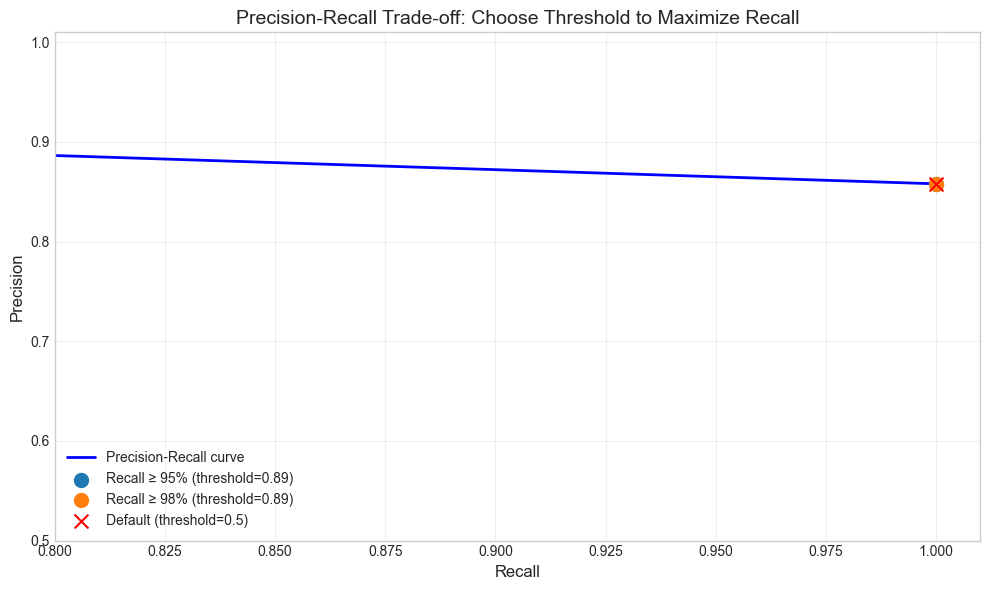

In [46]:
# Plot precision-recall curve with threshold markers
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the curve
ax.plot(recalls, precisions, 'b-', linewidth=2, label='Precision-Recall curve')

# Mark key thresholds
for target in [0.95, 0.98]:
    idx = np.where(recalls >= target)[0]
    if len(idx) > 0:
        best_idx = idx[-1]
        ax.scatter(recalls[best_idx], precisions[best_idx], s=100, zorder=5,
                  label=f'Recall ≥ {target:.0%} (threshold={thresholds[best_idx]:.2f})')

# Mark default threshold (0.5)
default_idx = np.argmin(np.abs(thresholds - 0.5))
ax.scatter(recalls[default_idx], precisions[default_idx], s=100, c='red', marker='x', zorder=5,
          label=f'Default (threshold=0.5)')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Trade-off: Choose Threshold to Maximize Recall', fontsize=14)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.8, 1.01])
ax.set_ylim([0.5, 1.01])

plt.tight_layout()
plt.savefig('images/fp_threshold_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

In [47]:
# Set optimal threshold for deployment (targeting 98% recall)
TARGET_RECALL = 0.98
idx = np.where(recalls >= TARGET_RECALL)[0]
if len(idx) > 0:
    best_idx = idx[-1]
    OPTIMAL_THRESHOLD = thresholds[best_idx]
else:
    OPTIMAL_THRESHOLD = 0.5  # Fallback to default

print("=" * 60)
print("OPTIMAL THRESHOLD FOR DEPLOYMENT")
print("=" * 60)
print(f"\nTarget recall: {TARGET_RECALL:.0%}")
print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.4f}")

# Evaluate with optimal threshold
y_pred_optimal = (y_proba >= OPTIMAL_THRESHOLD).astype(int)
optimal_recall = (y_pred_optimal[y_test == 1] == 1).mean()
optimal_precision = (y_test[y_pred_optimal == 1] == 1).mean()
fp_passed = ((y_pred_optimal == 1) & (y_test == 0)).sum()
fn_missed = ((y_pred_optimal == 0) & (y_test == 1)).sum()

print(f"\nWith optimal threshold on test set:")
print(f"  Recall:    {optimal_recall:.4f} ({fn_missed} sportswear articles missed)")
print(f"  Precision: {optimal_precision:.4f} ({fp_passed} false positives passed to LLM)")
print(f"\nThis means:")
print(f"  - Only {fn_missed} out of {(y_test == 1).sum()} sportswear articles will be missed")
print(f"  - {fp_passed} false positives will be correctly caught by the LLM")
print("=" * 60)

# Save the threshold
config = {
    'threshold': OPTIMAL_THRESHOLD,
    'target_recall': TARGET_RECALL,
    'best_tfidf_params': best_tfidf_params,
}
config_path = models_dir / 'fp_classifier_config.joblib'
joblib.dump(config, config_path)
print(f"\nConfiguration saved to {config_path}")

OPTIMAL THRESHOLD FOR DEPLOYMENT

Target recall: 98%
Optimal threshold: 0.8927

With optimal threshold on test set:
  Recall:    1.0000 (0 sportswear articles missed)
  Precision: 0.8580 (24 false positives passed to LLM)

This means:
  - Only 0 out of 145 sportswear articles will be missed
  - 24 false positives will be correctly caught by the LLM

Configuration saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.joblib


In [48]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBest Model: {best_model_name}")
print(f"\nTest Set Performance:")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F2 Score:  {test_metrics['f2']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  F1 Score:  {test_metrics['f1']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  PR-AUC:    {test_metrics['pr_auc']:.4f}")
print("="*60)

FINAL RESULTS SUMMARY

Best Model: LR_tuned

Test Set Performance:
  Recall:    1.0000
  F2 Score:  0.9680
  Precision: 0.8580
  F1 Score:  0.9236
  Accuracy:  0.8580
  PR-AUC:    0.8580


### Next Steps

1. **Deploy Model**: Integrate the classifier into the labeling pipeline to filter false positives before Claude labeling
2. **Monitor Performance**: Track precision/recall on new data to detect drift
3. **Retrain Periodically**: Update model as more labeled data becomes available
4. **Consider Deep Learning**: If more data is collected, try transformer-based models (DistilBERT)